In [1]:
import numpy as np
import matplotlib.pyplot as plt

import preprocessing as prep
import visualization as vis
from filtering import LPF

In [2]:
DATA_DIR = "titan-hf-4"

SENSORS = {"b_load_1": "LC1 Axial Load",
           "pres_1": "PT1 Combustion Chamber Pressure",
           "pres_2": "PT2 Feedline Pressure",
           "pres_3": "PT3 Injector Pressure",
           "pres_4": "PT4 Ox-Tank Pressure"}

DRIVERS = {0: {"name": "Ox Fill", "false": "Close", "true": "Open"},
           1: {"name": "Ground Vent", "false": "Close", "true": "Open"},
           2: {"name": "Pressurization", "false": "Open", "true": "Close"},
           3: {"name": "Engine Vent", "false": "Close", "true": "Open"},
           4: {"name": "Ignition", "false": "Shutoff", "true": "Ignite"}}

In [ ]:
# Manually locating timestamps for events

prep.process_data(DATA_DIR, SENSORS)
from time import time


contents = []
ignition_index = 0
samples_before_ignition = 0

with open(f"{DATA_DIR}/data-raw/console.log", 'r') as file:
    while True:
        line = file.readline()
        if len(line) <= 1:
            break
        contents.append(line)
for message in contents:
    if "Ignition in 10" in message:
        print(message, contents.index(message))
        ignition_index = contents.index(message)
        break
#gets the data log of the number of samples sent to approximate
#the 'start time'
for idx in range(ignition_index,0,-1):
    if "samples obtained" in contents[idx]:
        samples_before_ignition = int(contents[idx].split(':')[2].split()[0])
        temp_index = contents.index(contents[idx])
        message_count = 0
        for i in range(temp_index, ignition_index, 1):
            if "Sending data to" in contents[i]:
                message_count += 1   
        time_since_start_approx = round(samples_before_ignition/300)
        time_since_start = time_since_start_approx + round(message_count/2)
        break


INFO:data_to_dash:Broadcasting message: 'Ignition in 10...'
 41406
6509 seconds
1952000


In [3]:
print("Processing events")
# prep.process_events(DATA_DIR, DRIVERS)
print("Processing data")
prep.process_data(DATA_DIR, SENSORS)
print("Done!")
# 33
# 6509

Processing events
Processing data
Done!


In [7]:
# events = prep.import_events(DATA_DIR)
# print(events[52])
events = [{'secs': '6519', 'elapsed': '00:00', 'delta': '00:00', 'type': 'Ignition', 'info': ''}, {'secs': '6709', 'elapsed': '00:00', 'delta': '00:00', 'type': 'End', 'info': ''}]
labels, data = prep.import_data(DATA_DIR, events)
print(labels)
times = data[:, 0]
print(times)

print(f"HF4 Data Summary \n----------------- \n Sensors: {len(labels) - 1} \n" f" Samples: {len(times)} \n Events:  {len(events)}")

['Time (s)' 'LC1 Axial Load' 'PT1 Combustion Chamber Pressure'
 'PT2 Feedline Pressure' 'PT3 Injector Pressure' 'PT4 Ox-Tank Pressure']
[0.00000000e+00 3.33000000e-03 6.67000000e-03 ... 6.70899333e+03
 6.70899667e+03 6.70900000e+03]
HF4 Data Summary 
----------------- 
 Sensors: 5 
 Samples: 2012701 
 Events:  2


In [8]:
ep = vis.EventPlotter(data, events, dpi=100)
lpf = LPF(fs=300, length=101, cutoff=10, window="blackman")

6519.0
1955700
[-21.43758 -31.84558 -21.43758 ... -24.03958 -24.03958 -26.64158]


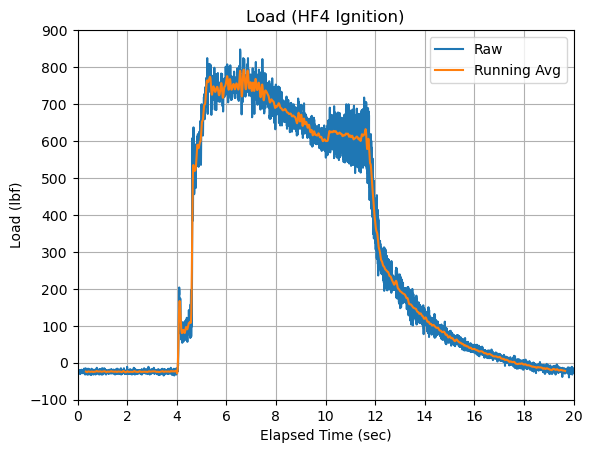

In [9]:
ep.plot(sensor_id=1, event_id=0, duration=20, filter=lpf,
        title="Load (HF4 Ignition)", ylabel="Load (lbf)",
        num_xticks=11, dif_yticks=100)

6519.0
1955700
[-21.43758 -31.84558 -21.43758 ... -24.03958 -24.03958 -26.64158]


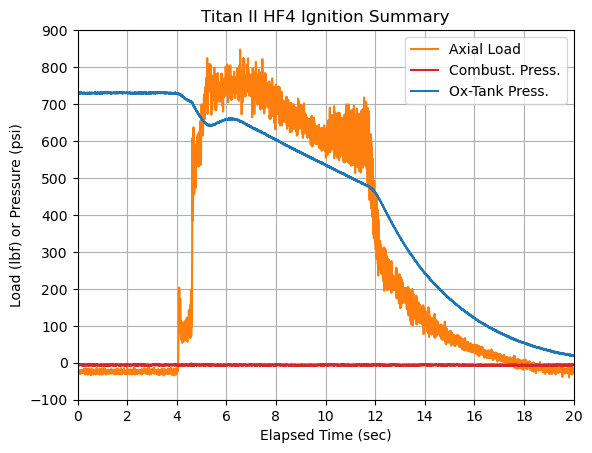

In [10]:
ep.plot(sensor_id=1, event_id=0, duration=20, filter=None,
        title="Titan II HF4 Ignition Summary", ylabel="Load (lbf) or Pressure (psi)",
        legend="Axial Load", num_xticks=11, dif_yticks=100, color="tab:orange")
ep.add_curve(sensor_id=2, event_id=0, duration=20, legend="Combust. Press.",
             color="tab:red")
ep.add_curve(sensor_id=5, event_id=0, duration=20, legend="Ox-Tank Press.", 
             color="tab:blue")
plt.show()

In [11]:
time_start = float(events[0]["secs"])
time_end = time_start + 20
sample_start = vis.nearest_sample(data, time_start)
sample_end = vis.nearest_sample(data, time_end)

times_event = [t - time_start for t in times[sample_start : sample_end]]
data_event = data[sample_start : sample_end, 1]

offset = np.mean(data_event[0:1081])

impulse_total = 0
for sample in data_event[1081:]:
    impulse_total += (sample - offset) / 300

impulse_main = 0
for sample in data_event[1081:3915]:
    impulse_main += (sample - offset) / 300

peak_thrust = max(data_event) - offset
peak_sustained_thrust = np.mean(data_event[int(300*6.25) : int(300*6.3)]) - offset
avg_thrust = impulse_main / ((3915 - 1081) / 300)

print(f"Peak Thrust:\t\t  {peak_thrust:.2f}  lbf")
print(f"Peak Sustained Thrust:\t   {peak_sustained_thrust:.2f}  lbf")
print(f"Avg Thrust @ Supersonic:   {avg_thrust:.2f}  lbf")
print(f"Impulse @ Supersonic:\t  {impulse_main:.2f}  lb-sec")
print(f"Total Impulse:\t\t  {impulse_total:.2f}  lb-sec")

Peak Thrust:		  871.69  lbf
Peak Sustained Thrust:	   773.07  lbf
Avg Thrust @ Supersonic:   579.43  lbf
Impulse @ Supersonic:	  5473.70  lb-sec
Total Impulse:		  5930.58  lb-sec


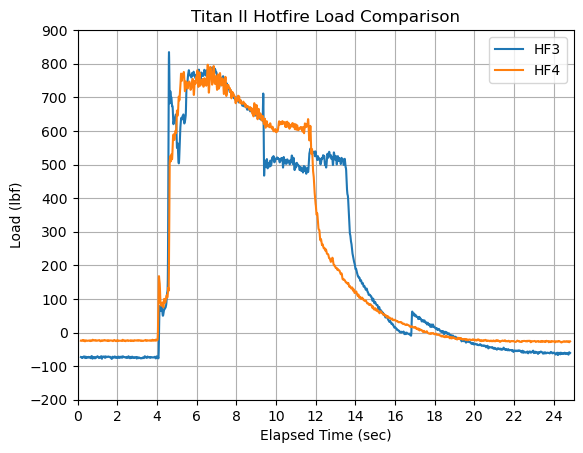

In [21]:
lpf = LPF(fs=300, length=51, cutoff=15, window="blackman")

DATA_DIR_HF3 = "titan-hf-3"
events_hf3 = prep.import_events(DATA_DIR_HF3)
label_hf3, data_hf3 = prep.import_data(DATA_DIR_HF3, events_hf3)
times_hf3 = data_hf3[:, 0]

time_start = float(events[0]["secs"])
time_end = time_start + 25
sample_start = vis.nearest_sample(data, time_start)
sample_end = vis.nearest_sample(data, time_end)
times_event = [t - time_start for t in times[sample_start:sample_end]]
data_event = data[sample_start:sample_end, 1]

time_start_hf3 = float(events_hf3[52]["secs"]) - 0.5
time_end_hf3 = time_start_hf3 + 25
sample_start_hf3 = vis.nearest_sample(data_hf3, time_start_hf3)
sample_end_hf3 = vis.nearest_sample(data_hf3, time_end_hf3)
times_event_hf3 = [t - time_start_hf3 for t in times_hf3[sample_start_hf3:sample_end_hf3]]
data_event_hf3 = data_hf3[sample_start_hf3:sample_end_hf3, 1]

plt.figure(dpi=100)
plt.plot(times_event_hf3[51:-51],
         lpf.apply(data_event_hf3)[51:-51],
         label="HF3", c="tab:blue")
plt.plot(times_event[51:-51],
         lpf.apply(data_event)[51:-51],
         label="HF4", c="tab:orange")
plt.legend(); plt.grid()
plt.title("Titan II Hotfire Load Comparison")
plt.xlabel("Elapsed Time (sec)"); plt.ylabel("Load (lbf)")
plt.xlim((0, 25)); plt.ylim((-200, 900))
plt.xticks(range(0, 26, 2)); plt.yticks(range(-200, 1000, 100))
plt.show()